# Survey results processing

In this script, we:
- assemble the row survey data into a dataset for further media bias analysis,
- retrieve descriptive statistics of the assembled dataset.

To run this script, the following data files are needed (attached):
- annotations_final_notempty.xlsx
- sentences_final.xlsx
- biased_words_analysis.xlsx
- articles.xlsx
- labeled_dataset.xlsx
- annotators.csv

In [119]:
# data
import pandas as pd
import numpy as np

# misc
import os
import re
import time
import ast
import copy
from newsplease import NewsPlease

# statistics
import statistics
import statsmodels
from statsmodels.stats import inter_rater

# visualizations
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import plotly.express as px
from matplotlib import colors

## 1 Dataset assembling

In [120]:
# upload annotation results without rejected ones and without the following ones:
#os.chdir('/Users/Lenovo/Desktop/Master Thesis/4. Survey/Results processing')
#os.chdir('E:\German Autolabs Laptop\sultan\Thesis\Code\Classic-ML-Automated-Identification-of-Bias-Inducing-Words-in-News-Articles\1.1_Survey_results_processing')
annotations = pd.read_excel("data/annotations_final_notempty.xlsx",engine='openpyxl')
annotations['political_ideology_lcr'] = annotations['political_ideology'].apply(lambda x: "left" if x < -3
                                                                                else ("right" if x > 3 else "center"))
annotations["followed_news_outlets"] = annotations.followed_news_outlets.apply(lambda s: list(ast.literal_eval(s)))

annotations.head(2)

,Unnamed: 0.1,Unnamed: 0,survey_record_id,sentence_id,group_id,created_at,label,words,factual,group_id.1,...,mturk_id,age,gender,education,native_english_speaker,political_ideology,followed_news_outlets,news_check_frequency,survey_completed,political_ideology_lcr
0,0,19227,73a9148bc907314e086de8debe345824,1942,67,NaN,Biased,"match-fixing,infamous,notorious",Entirely factual,67,...,73a9148bc907314e086de8debe345824,26.0,prefer not to say,graduate work,near native,18,"[Reuters, BuzzFeed]",several times per month,True,right
1,1,19228,73a9148bc907314e086de8debe345824,1620,67,NaN,Biased,high,Expresses writer’s opinion,67,...,73a9148bc907314e086de8debe345824,26.0,prefer not to say,graduate work,near native,18,"[Reuters, BuzzFeed]",several times per month,True,right


In [121]:

all_sentences = pd.read_excel("data/sentences_final.xlsx",engine='openpyxl')
all_sentences.head(2)

,sentence,news_link,outlet,topic,type,group_id,num_sent,Unnamed: 7
0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,NaN
1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,NaN


In [122]:
# pivoting
turker_words = annotations.pivot(index='text', columns='survey_record_id', values='words')
turker_bias = annotations.pivot(index='text', columns='survey_record_id', values='label')
turker_opin = annotations.pivot(index='text', columns='survey_record_id', values='factual')

### 1.1 Labels - biased/non-biased

In [123]:
turker_bias["Biased"] = turker_bias.apply(lambda row: sum(row[1:len(turker_bias.columns)]=="Biased") ,axis=1)
turker_bias["Non-biased"] = turker_bias.apply(lambda row: sum(row[1:(len(turker_bias.columns)-1)]=="Non-biased") ,axis=1)
results_bias = turker_bias[["Biased", 'Non-biased']]
results_bias["Label_bias"] = results_bias.apply(lambda row: "Biased" if row["Biased"]>((row["Biased"]+row["Non-biased"])/2) else ("Non-biased" if row["Non-biased"]>((row["Biased"]+row["Non-biased"])/2) else "No agreement"), axis=1)

results_bias["Total_annotations"] = results_bias["Biased"] + results_bias["Non-biased"]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4992\3785490413.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4992\3785490413.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [124]:
results_bias.head(25)

survey_record_id,Biased,Non-biased,Label_bias,Total_annotations
text,,,,
"A 10-hour hearing broadcast on the courtâ€™s website showed Sun, China's greatest ever swimmer, and one of its biggest sports stars, to be evasive at times under questioning that was hampered by severe translation issues between Chinese and English.",0,1,Non-biased,1
A Guatemalan mom who says she sustained severe chemical burns and was sexually assaulted in front of her young daughter during a kidnapping in Mexico is asking the U.S. government to let her into the country while her asylum case plays out.,0,1,Non-biased,1
"A federal judge dismissed the United States womenâ€™s soccer teamâ€™s bid for equal pay on Friday, rejecting claims the players had been underpaid in a crushing defeat for the reigning world champions.",1,0,Biased,1
"A federal judge in Tucson, Arizona delivered a blow Monday to the Trump administrationâ€™s strategy of criminalizing humanitarian aid work along the southern border with her decision to overturn the convictions of four volunteers on religious freedom grounds.",1,1,No agreement,2
"A poll released Tuesday finds 75 percent of Americans want substantial restrictions on abortion, including 60 percent of Democrats and 61 percent of those who identify as â€œpro-choice.â€",0,1,Non-biased,1
AP Confirms: Democrats Are Lying to the Public About Coronavirus Readiness...,1,0,Biased,1
"Abortion propaganda was always meant to obscure the reality of abortion, not justify it.",1,0,Biased,1
"After tremendous pressure on the Department of Homeland Security, Miller is advancing his agenda of not just blocking migrants from entering the country illegally, but making life in the U.S. so unbearable for legal immigrants that they leave the country.",1,0,Biased,1
"After walking off following another hardcourt loss to Novak Djokovic, allowing Serbia to level the final after Roberto Bautista Agut won the opening singles for Spain, Nadal urged the men's tour and the sport's international governing body to form one major team tournament.",1,1,No agreement,2


In [125]:

# results_bias.to_excel('results_bias.xlsx')

In [126]:
no_ag_bias = results_bias[results_bias['Label_bias']=='No agreement']
print("Out of", len(results_bias), len(no_ag_bias), "have no agreement.")

Out of 148 11 have no agreement.


In [127]:
results_bias10 = results_bias[results_bias['Total_annotations']==10]

fk_bias = inter_rater.fleiss_kappa(results_bias10[["Biased","Non-biased"]], method='fleiss')

print("Fleiss Kappa for annotation on whether the sentence is biased/impartial:", 
      round(fk_bias,2), "(Fair agreement)")

ValueError: zero-size array to reduction operation maximum which has no identity

### 1.2 Labels - opinionated/factual

In [128]:
turker_opin["Entirely factual"] = turker_opin.apply(lambda row: sum(row[1:len(turker_opin.columns)]=="Entirely factual") ,axis=1)
turker_opin["Somewhat factual but also opinionated"] = turker_opin.apply(lambda row: sum(row[1:(len(turker_opin.columns)-1)]=="Somewhat factual but also opinionated") ,axis=1)
turker_opin["Expresses writer’s opinion"] = turker_opin.apply(lambda row: sum(row[1:(len(turker_opin.columns)-2)]=="Expresses writer’s opinion") ,axis=1)

results_opin = turker_opin[["Entirely factual", 'Somewhat factual but also opinionated', "Expresses writer’s opinion"]]

results_opin["max_Label_opinion"] = results_opin.apply(lambda row: max(row["Entirely factual"],
                                                                      row["Somewhat factual but also opinionated"],
                                                                       row["Expresses writer’s opinion"]), axis=1)
results_opin["Label_opinion"] = results_opin.apply(lambda row: "No agreement" if ((row["Entirely factual"]==row["max_Label_opinion"] and row["Somewhat factual but also opinionated"]==row["max_Label_opinion"]) 
                                                   or (row["Entirely factual"]==row["max_Label_opinion"] and row["Expresses writer’s opinion"]==row["max_Label_opinion"])
                                                   or (row["Somewhat factual but also opinionated"]==row["max_Label_opinion"] and row["Expresses writer’s opinion"]==row["max_Label_opinion"]))
                                                   else ("Entirely factual" if row["Entirely factual"]==row["max_Label_opinion"]
                                                        else "Somewhat factual but also opinionated" if row["Somewhat factual but also opinionated"]==row["max_Label_opinion"]
                                                        else "Expresses writer’s opinion")
                                                   , axis=1)

results_opin = results_opin[["Entirely factual", "Somewhat factual but also opinionated", 
                             "Expresses writer’s opinion", "Label_opinion"]]

results_opin["Total_annotations"] = results_opin["Entirely factual"] + results_opin["Somewhat factual but also opinionated"] + results_opin["Expresses writer’s opinion"]


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4992\46001291.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4992\46001291.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [129]:
results_opin.head(15)

survey_record_id,Entirely factual,Somewhat factual but also opinionated,Expresses writer’s opinion,Label_opinion,Total_annotations
text,,,,,
"A 10-hour hearing broadcast on the courtâ€™s website showed Sun, China's greatest ever swimmer, and one of its biggest sports stars, to be evasive at times under questioning that was hampered by severe translation issues between Chinese and English.",1,0,0,Entirely factual,1
A Guatemalan mom who says she sustained severe chemical burns and was sexually assaulted in front of her young daughter during a kidnapping in Mexico is asking the U.S. government to let her into the country while her asylum case plays out.,0,0,1,Expresses writer’s opinion,1
"A federal judge dismissed the United States womenâ€™s soccer teamâ€™s bid for equal pay on Friday, rejecting claims the players had been underpaid in a crushing defeat for the reigning world champions.",1,0,0,Entirely factual,1
"A federal judge in Tucson, Arizona delivered a blow Monday to the Trump administrationâ€™s strategy of criminalizing humanitarian aid work along the southern border with her decision to overturn the convictions of four volunteers on religious freedom grounds.",1,0,1,No agreement,2
"A poll released Tuesday finds 75 percent of Americans want substantial restrictions on abortion, including 60 percent of Democrats and 61 percent of those who identify as â€œpro-choice.â€",1,0,0,Entirely factual,1
AP Confirms: Democrats Are Lying to the Public About Coronavirus Readiness...,0,1,0,Somewhat factual but also opinionated,1
"Abortion propaganda was always meant to obscure the reality of abortion, not justify it.",0,1,0,Somewhat factual but also opinionated,1
"After tremendous pressure on the Department of Homeland Security, Miller is advancing his agenda of not just blocking migrants from entering the country illegally, but making life in the U.S. so unbearable for legal immigrants that they leave the country.",0,0,1,Expresses writer’s opinion,1
"After walking off following another hardcourt loss to Novak Djokovic, allowing Serbia to level the final after Roberto Bautista Agut won the opening singles for Spain, Nadal urged the men's tour and the sport's international governing body to form one major team tournament.",0,2,0,Somewhat factual but also opinionated,2


In [12]:

# results_opin.to_excel('results_opin.xlsx')

In [130]:
no_ag_opin = results_opin[results_opin['Label_opinion']=='No agreement']
print("Out of", len(results_opin), len(no_ag_opin), "have no agreement.")

Out of 148 16 have no agreement.


In [131]:
results_opin10 = results_opin[results_opin['Total_annotations']==10]

fk_opinion = inter_rater.fleiss_kappa(results_opin10[["Entirely factual", "Expresses writer’s opinion", 
                                                    "Somewhat factual but also opinionated"]], method='fleiss')

print("Fleiss Kappa for annotation on whether the sentence is opinionated/factual:", 
      round(fk_opinion,2), "(Slight agreement)")

ValueError: zero-size array to reduction operation maximum which has no identity

### 1.3 Biased words

#### 1.3.1 Count frequency of highlighted words

In [132]:
survey_codes = list(turker_words)
results_words = turker_words.copy(deep = True)

for survey in survey_codes: 
    # remove quotation marks, spaces and dots. Split string to list of selected words
    results_words[survey] = results_words[survey].apply(lambda x: re.sub(r'“', '', x) if pd.isna(x) == False else x)
    results_words[survey] = results_words[survey].apply(lambda x: re.sub(r'”', '', x) if pd.isna(x) == False else x)
    results_words[survey] = results_words[survey].apply(lambda x: re.sub(r'\.', '', x) if pd.isna(x) == False else x)
    results_words[survey] = results_words[survey].apply(lambda x: x.split(',') if pd.isna(x) == False else x)

results_words = results_words.where(pd.notnull(results_words), None)

In [134]:
results_words["Words_freq"] = [{} for _ in range(len(results_words))]

for ind in results_words.index: # iterate over each sentence
    for survey in survey_codes: # iterate over columns to include each survey
        if results_words[survey][ind] != None:
            for word in results_words[survey][ind]:
                word_ = word.strip() # remove whitespaces from the beginning and end
                if word_ in results_words["Words_freq"][ind]:
                    results_words["Words_freq"][ind][word_] += 1
                else:
                    results_words["Words_freq"][ind][word_] = 1

results_words = pd.merge(results_words, results_bias, left_index = True, right_index = True, how='left')

results_words = results_words[["Words_freq", "Total_annotations"]]
results_words = results_words.reset_index()
results_words.head(25)

TypeError: 'numpy.float64' object is not iterable

In [135]:
def update_annotations(d):
    d_upd = {}
    for p in d:
        w_list = p.split(" ")
        for w in w_list:
            if w in d_upd:
                d_upd[w]+=d[p]
            else:
                d_upd[w]=d[p]
    return(d_upd)

results_words["biased_upd"] = results_words.apply(lambda row: update_annotations(row['Words_freq']), axis=1)
results_words['words_freq_manual'] = None

# biased_words_analysis.to_excel("biased_words_analysis.xlsx")

We manually go through all the sentences, correct mistakes in annotations, and decide on the reasonable threshold. Corrected annotations are in the column "words_freq_manual". The threshold is chosen to be 4.

#### 1.3.2 Select only words highlighted at least 4 times

In [136]:
# words selected more than 4 times
def list_biased_words(dic):
    biased = {k: v for k, v in dic.items() if v >= 4}
    biased = list(biased.keys())
    return(biased)

In [137]:

annotations_words = pd.read_excel("data/biased_words_analysis.xlsx",engine='openpyxl')
annotations_words['words_freq_manual_dic']=annotations_words['words_freq_manual'].apply(lambda s: ast.literal_eval(s))
annotations_words['biased_words4'] = annotations_words.apply(lambda row: list_biased_words(row['words_freq_manual_dic']), axis=1)
annotations_biased_words = annotations_words[['text','Total_annotations','biased_words4']]
annotations_biased_words.head(10)

,text,Total_annotations,biased_words4
0,"Gautney consented to this field, job, and cit...",11,"[bailed, unsuspecting]"
1,Trade jobs such as electricians or carpenters...,10,[deter]
2,While conservatives may find comfort in the o...,10,"[brain, statists]"
3,"""Orange Is the New Black"" star Yael Stone is r...",12,[renouncing]
4,"...immigrants as criminals and eugenics, all o...",10,[]
5,...we sounded the alarm in the early months of...,11,"[alarm, inherently, threat]"
6,A 10-hour hearing broadcast on the court’s web...,9,"[evasive, greatest, ever]"
7,"A 60-foot chunk of the Ocean Cleanup device, d...",10,[fanfare]
8,A 70% majority of Americans view the economy a...,11,[unfairly]
9,A Catholic priest in Rhode Island who barred s...,12,"[abortion, worse, than, pedophilia]"


### 1.4 Final labeled sentences

In [138]:
# download articles
# articles = all_sentences.replace({np.nan: None})
# articles['article'] = None

# for index, row in articles.iterrows():
#     if row['news_link'] != None:
#         try:
#             print(index)
#             articles.at[index,'article'] = NewsPlease.from_url(row['news_link']).maintext
#         except:
#             print(index, "An exception occurred")
            
# articles = articles[['sentence','article']]

# articles.to_excel("articles.xlsx")

In [139]:

all_articles = pd.read_excel("data/articles.xlsx",engine='openpyxl')

In [140]:
labeled_sentences = pd.merge(all_sentences, results_bias,
                           left_on = 'sentence', right_index = True,
                           how='left')
labeled_sentences = pd.merge(labeled_sentences, results_opin,
                           left_on = 'sentence', right_index = True,
                           how='left')
labeled_sentences = pd.merge(labeled_sentences, annotations_biased_words,
                           left_on = 'sentence', right_on = 'text',
                           how='left')
labeled_sentences = pd.merge(labeled_sentences, all_articles,
                           left_on = 'sentence', right_on = 'sentence',
                           how='left')
labeled_sentences = labeled_sentences[['sentence',
 'news_link',
 'outlet',
 'topic',
 'type',
 'group_id',
 'num_sent',
 'Label_bias',
 'Label_opinion',
 'biased_words4',
 'article']]

print('len:', len(labeled_sentences))
print('Is there missing values?', labeled_sentences.isnull().values.any())
print('Number of missing values:\n', labeled_sentences.isnull().sum())

len: 1700
Is there missing values? True
Number of missing values:
 sentence            0
news_link           0
outlet              0
topic               0
type                0
group_id            0
num_sent            0
Label_bias       1619
Label_opinion    1619
biased_words4       0
article           100
dtype: int64


In [141]:
labeled_sentences.head(3)

,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,biased_words4,article
0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,NaN,NaN,"[belated, birtherism]",YouTube says no ‘deepfakes’ or ‘birther’ video...
1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,NaN,NaN,[bitter],"FRISCO, Texas — The increasingly bitter disput..."
2,So while there may be a humanitarian crisis dr...,https://www.alternet.org/2019/01/here-are-5-of...,alternet,immigration,left,1,1,NaN,NaN,[crisis],Speaking to the country for the first time fro...


In [ ]:

# labeled_sentences.to_excel('labeled_dataset.xlsx')

## 2 Descriptive statistics

### 2.1 Dataset exploration

In [142]:

sentences = pd.read_excel('data/labeled_dataset.xlsx',engine='openpyxl')

In [143]:
sentences.head(3)

,Unnamed: 0,sentence,news_link,outlet,topic,type,group_id,num_sent,Label_bias,Label_opinion,article,biased_words4
0,0,YouTube is making clear there will be no “birt...,https://eu.usatoday.com/story/tech/2020/02/03/...,usa-today,elections-2020,center,1,1,Biased,Somewhat factual but also opinionated,YouTube says no ‘deepfakes’ or ‘birther’ video...,"['belated', 'birtherism']"
1,1,The increasingly bitter dispute between Americ...,https://www.nbcnews.com/news/sports/women-s-te...,msnbc,sport,left,1,1,Non-biased,Entirely factual,"FRISCO, Texas — The increasingly bitter disput...",['bitter']
2,2,So while there may be a humanitarian crisis dr...,https://www.alternet.org/2019/01/here-are-5-of...,alternet,immigration,left,1,1,Biased,Expresses writer’s opinion,Speaking to the country for the first time fro...,['crisis']


In [144]:
# outlets
types_outlets = sentences.groupby(['type','outlet'])[['sentence']].count()
types_outlets = types_outlets.reset_index()
types_outlets = types_outlets.rename(columns={"sentence": "num_sentences"})
types_outlets

,type,outlet,num_sentences
0,center,reuters,158
1,center,usa-today,157
2,left,alternet,338
3,left,huffpost,114
4,left,msnbc,242
5,right,breitbart,377
6,right,federalist,203
7,right,fox-news,111


In [148]:
fig = px.sunburst(data_frame = types_outlets,
                  path = ['type', 'outlet'],
                  values = 'num_sentences',
                  color='type',
                  color_discrete_map={'center':'thistle', 'left':'steelblue','right':'indianred'})
fig.update_traces(textfont_size=20)
fig.show()

In [149]:
# topics
topics = sentences.groupby(['topic'])[['sentence']].count()
topics = topics.reset_index()
topics = topics.rename(columns={"sentence": "num_sentences"})
topics = topics.replace('international-politics-and-world-news', 'int.-politics-&-world-news')

topics

,topic,num_sentences
0,abortion,126
1,coronavirus,122
2,elections-2020,111
3,environment,135
4,gender,128
5,gun-control,124
6,immigration,122
7,int.-politics-&-world-news,88
8,middle-class,118
9,sport,126


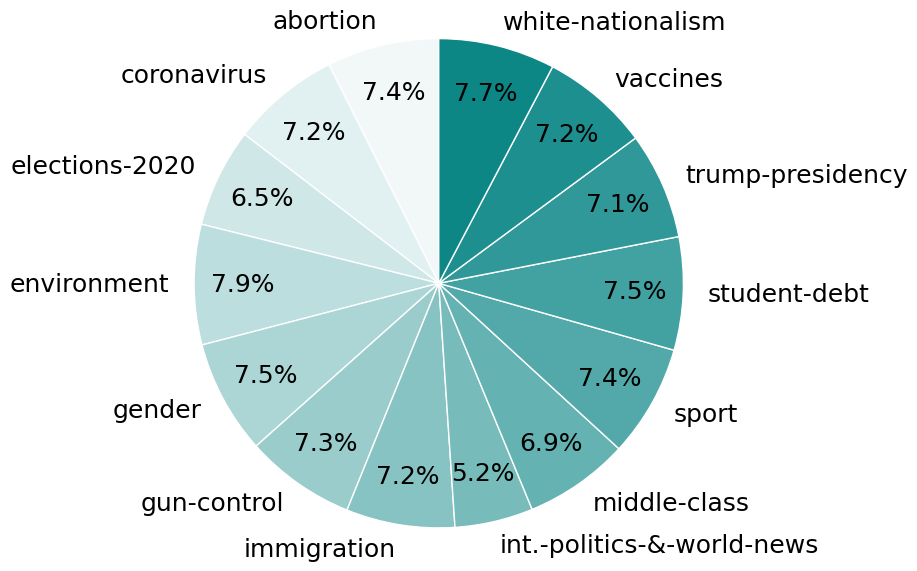

In [150]:
alphas = np.linspace(0.05, 0.95, 14)
teal_rgba = np.array([np.array(list(colors.to_rgba('teal', alpha=None))),]*14)
teal_rgba[:, 3] = alphas
teal_rgba

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 3 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(topics.num_sentences, labels=topics.topic,
        startangle=90, textprops={'fontsize': 18}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=teal_rgba)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right') #, bbox_to_anchor=(1.24, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()

### 2.2 Who are our annotators?

In [151]:

all_annotators = pd.read_excel('data/annotators.xlsx',engine='openpyxl')

#annotators = all_annotators[all_annotators.id.isin(set(annotations.survey_record_id))]
annotators = all_annotators[all_annotators.id.isin(set(all_annotators.id))]

annotators = annotators.drop_duplicates(subset=['mturk_id'])
annotators['political_ideology_lcr'] = annotators['political_ideology'].apply(lambda x: "left" if x < -3
                                                                                else ("right" if x > 3 else "center"))
#annotators["followed_news_outlets"] = annotators.followed_news_outlets.apply(lambda s: list(ast.literal_eval(s)))

print('Total number of annotators:', len(annotators))
#print(len(all_annotators))

Total number of annotators: 20


In [152]:
annotators.head(2)

,id,mturk_id,age,gender,education,native_english_speaker,political_ideology,followed_news_outlets,news_check_frequency,survey_completed,political_ideology_lcr
0,73a9148bc907314e086de8debe345824,73a9148bc907314e086de8debe345824,26,prefer not to say,graduate work,near native,18,"Reuters,BuzzFeed",several times per month,True,right
1,efdbdfb640615da88d14815a06cbf499,efdbdfb640615da88d14815a06cbf499,29,male,bachelor 's degree,near native,10,The Guardian,very rarely,True,right


In [153]:
# age distribution
annotators_age = annotators.groupby(['age'])[['id']].count()
annotators_age = annotators_age.reset_index()
annotators_age = annotators_age.rename(columns={"id": "num_participants"})
annotators_age['age_bins'] = pd.cut(x=annotators_age['age'], bins=[0, 20, 30, 40, 50, 60, 70, 80])

annotators_age = annotators_age[annotators_age['age']>0]

annotators_age = annotators_age.groupby(['age_bins'])[['num_participants']].sum()
annotators_age = annotators_age.reset_index()
annotators_age

,age_bins,num_participants
0,"(0, 20]",0
1,"(20, 30]",16
2,"(30, 40]",4
3,"(40, 50]",0
4,"(50, 60]",0
5,"(60, 70]",0
6,"(70, 80]",0


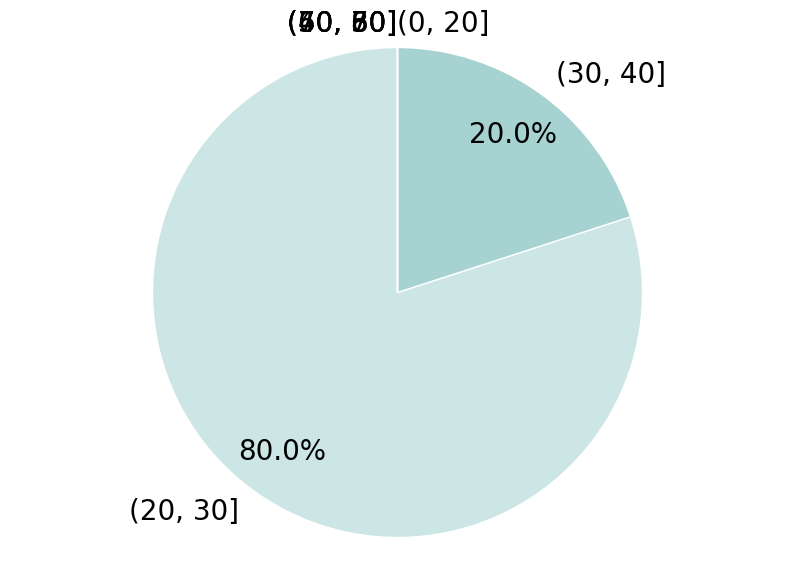

In [154]:
alphas = np.linspace(0.05, 0.95, 7)
teal_rgba = np.array([np.array(list(colors.to_rgba('teal', alpha=None))),]*7)
teal_rgba[:, 3] = alphas
teal_rgba

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 3 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(annotators_age.num_participants, labels=annotators_age.age_bins,
        startangle=90, textprops={'fontsize': 20}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=teal_rgba)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right') #, bbox_to_anchor=(1.24, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()

In [157]:
# gender distribution
annotators_gender = annotators.groupby(['gender'])[['id']].count()
annotators_gender = annotators_gender.reset_index()
annotators_gender = annotators_gender.rename(columns={"id": "num_participants"})
annotators_gender

,gender,num_participants
0,female,1
1,male,17
2,prefer not to say,2


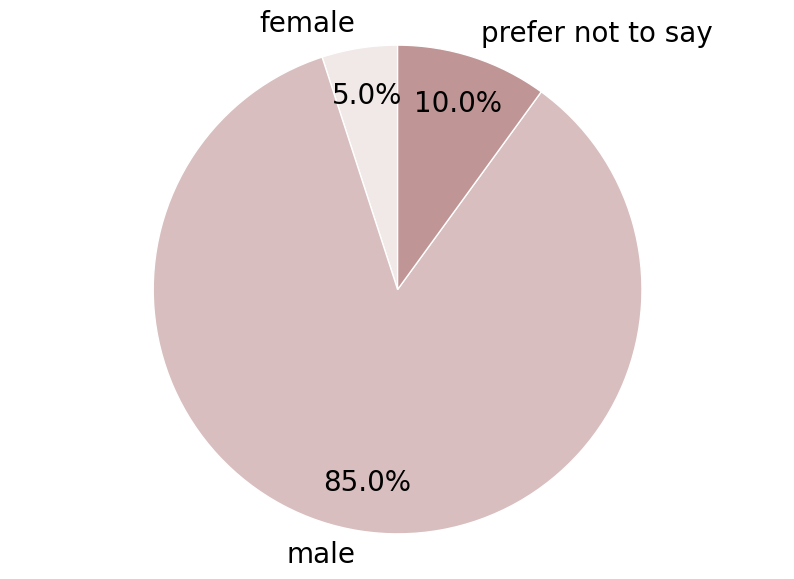

In [158]:
alphas = np.linspace(0.2, 0.95, 3)
teal_rgba = np.array([np.array(list(colors.to_rgba('rosybrown', alpha=None))),]*3)
teal_rgba[:, 3] = alphas
teal_rgba

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 3 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(annotators_gender.num_participants, labels=annotators_gender.gender,
        startangle=90, textprops={'fontsize': 20}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=teal_rgba)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right') #, bbox_to_anchor=(1.24, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()

In [159]:
# education
annotators_edu = annotators.groupby(['education'])[['id']].count()
annotators_edu = annotators_edu.reset_index()
annotators_edu = annotators_edu.rename(columns={"id": "num_participants"})
#annotators_edu['sorting'] = [5,6,7,2,8,4,1,3]
#annotators_edu = annotators_edu.sort_values(by=['sorting']).reset_index()
annotators_edu = annotators_edu[['education','num_participants']]
annotators_edu

,education,num_participants
0,bachelor 's degree,13
1,graduate work,5
2,high school graduation,1
3,some high school,1


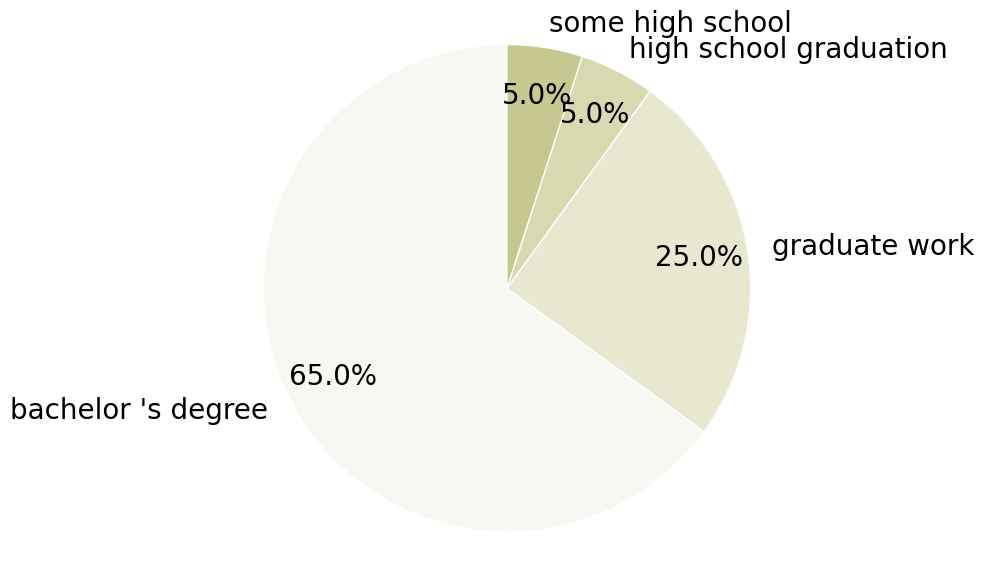

In [160]:
alphas = np.linspace(0.05, 0.95, 8)
teal_rgba = np.array([np.array(list(colors.to_rgba('olive', alpha=None))),]*8)
teal_rgba[:, 3] = alphas
teal_rgba

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 3 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(annotators_edu.num_participants, labels=annotators_edu.education,
        startangle=90, textprops={'fontsize': 20}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=teal_rgba)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()

In [161]:
# english knowledge
annotators_eng = annotators.groupby(['native_english_speaker'])[['id']].count()
annotators_eng = annotators_eng.reset_index()
annotators_eng = annotators_eng.rename(columns={"id": "num_participants"})
annotators_eng

,native_english_speaker,num_participants
0,near native,13
1,non native,7


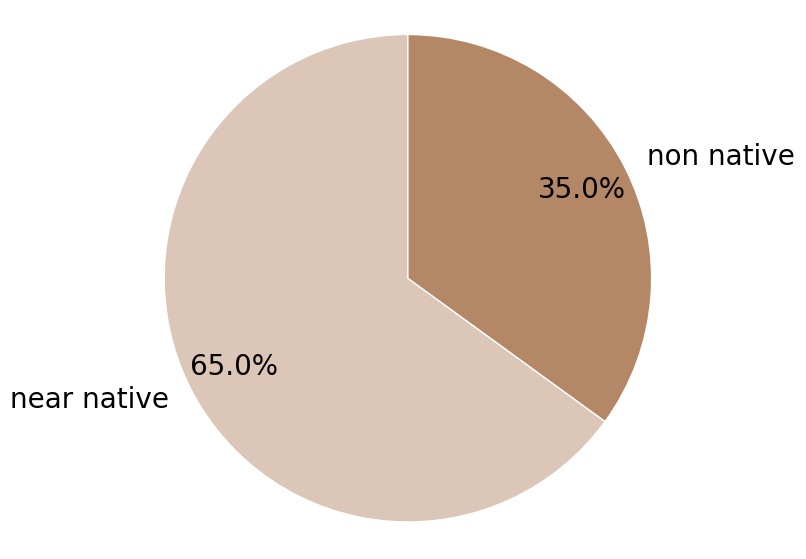

In [162]:
alphas = np.linspace(0.3, 0.99, 3)
teal_rgba = np.array([np.array(list(colors.to_rgba('saddlebrown', alpha=None))),]*3)
teal_rgba[:, 3] = alphas
teal_rgba

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 2 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(annotators_eng.num_participants, labels=annotators_eng.native_english_speaker,
        startangle=90, textprops={'fontsize': 20}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=teal_rgba)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()

In [163]:
# political orientation
annotators_polit = annotators.groupby(['political_ideology_lcr'])[['id']].count()
annotators_polit = annotators_polit.reset_index()
annotators_polit = annotators_polit.rename(columns={"id": "num_participants"})
annotators_polit['sorting'] = [2, 1, 3]
annotators_polit = annotators_polit.sort_values(by=['sorting']).reset_index()
annotators_polit = annotators_polit[['political_ideology_lcr','num_participants']]
annotators_polit = annotators_polit.replace('left', 'liberal')
annotators_polit = annotators_polit.replace('right', 'conservative')
annotators_polit

,political_ideology_lcr,num_participants
0,liberal,6
1,center,2
2,conservative,12


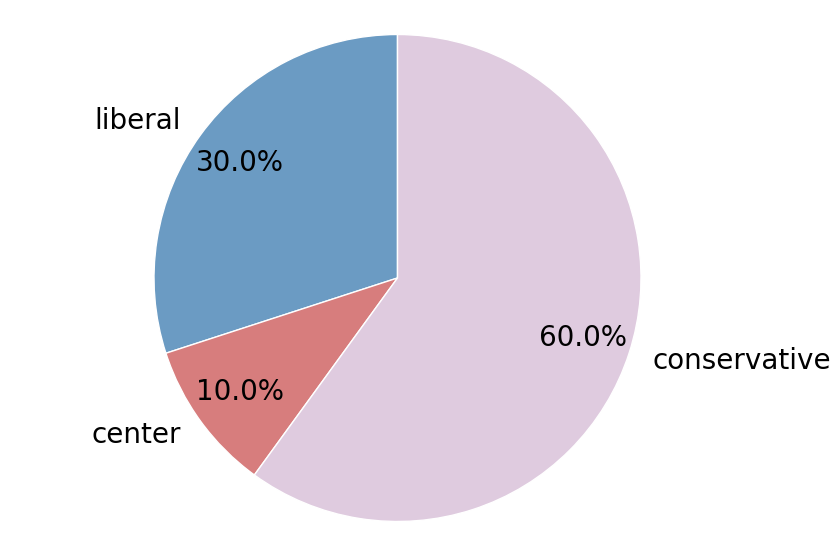

In [164]:
cols = np.array([
    np.array(colors.to_rgba('steelblue', alpha=0.8)),
    np.array(colors.to_rgba('indianred', alpha=0.8)),
    np.array(colors.to_rgba('thistle', alpha=0.8))])

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 2 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(annotators_polit.num_participants, labels=annotators_polit.political_ideology_lcr,
        startangle=90, textprops={'fontsize': 20}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=cols)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()

In [165]:
# followed news outlets
all_outlets = []
all_outlets_freq = {}

for ind in annotators.index:
    #print(type(annotators['followed_news_outlets'][ind]))
    for outlet in annotators['followed_news_outlets'][ind]:
        if outlet not in all_outlets:
            all_outlets.append(outlet)
            all_outlets_freq[outlet]=1
        else:
            all_outlets_freq[outlet]+=1
            
all_outlets_freq_filt = {}
all_outlets_freq_filt['misc']=0

for outlet in all_outlets_freq:
    if all_outlets_freq[outlet] > 5:
        all_outlets_freq_filt[outlet]=all_outlets_freq[outlet]
    else:
        all_outlets_freq_filt['misc']+=1

all_outlets_freq_filt

# pd
annotators_outlets = pd.DataFrame.from_dict(all_outlets_freq_filt, orient='index')
annotators_outlets = annotators_outlets.reset_index()
annotators_outlets = annotators_outlets.rename(columns={"index": "news_outlet",
                                                        0:"num_participants"})

# add slant from allsides
slant_allsides_dict = {'misc':'misc',
 'ABC News':'left',
 'CNN':'left',
 'MSNBC':'left',
 'The Washington Post':'left',
 'New York Post':'right',
 'New York Times':'left',
 'NPR':'center',
 'Fox News':'right',
 'Breitbart':'right',
 'The Wall Street Journal':'right',
 'Business Insider':'center',
 'Reuters':'center',
 'The Guardian':'left',
 'CBS News':'left',
 'USA Today':'center',
 'Time magazine':'left',
 'Vice':'left',
 'BuzzFeed':'left',
 'Huffington Post':'left',
 'The Federalist':'right',
 'BBC':'center'}

slant_allsides = pd.DataFrame.from_dict(slant_allsides_dict, orient='index')
slant_allsides = slant_allsides.reset_index()
slant_allsides = slant_allsides.rename(columns={"index": "news_outlet",
                                                        0:"slant_allsides"})

annotators_outlets = pd.merge(annotators_outlets, slant_allsides,
                             left_on='news_outlet', right_on='news_outlet', how='left')
annotators_outlets

,news_outlet,num_participants,slant_allsides
0,misc,18,misc
1,e,57,NaN
2,u,19,NaN
3,t,21,NaN
4,r,23,NaN
5,s,35,NaN
6,",",27,NaN
7,B,8,NaN
8,z,8,NaN
9,d,15,NaN


In [166]:
fig = px.sunburst(data_frame = annotators_outlets,
                  path = ['slant_allsides', 'news_outlet'],
                  values = 'num_participants',
                  color='slant_allsides',
                  color_discrete_map={'center':'thistle', 'left':'steelblue',
                                      'right':'indianred', 'misc':'dimgray'})
fig.update_traces(textfont_size=20)
fig.show()

ValueError: ('None entries cannot have not-None children', slant_allsides    nan
news_outlet          
Name: 12, dtype: object)

In [167]:
# news consumption frequency
annotators_cons = annotators.groupby(['news_check_frequency'])[['id']].count()
annotators_cons = annotators_cons.reset_index()
annotators_cons = annotators_cons.rename(columns={"id": "num_participants"})
#annotators_cons['sorting'] = [4, 0, 5, 2, 3, 1]
#annotators_cons = annotators_cons.sort_values(by=['sorting']).reset_index()
annotators_cons = annotators_cons[['news_check_frequency','num_participants']]
annotators_cons

,news_check_frequency,num_participants
0,every day,5
1,several times per day,3
2,several times per month,1
3,several times per week,9
4,very rarely,2


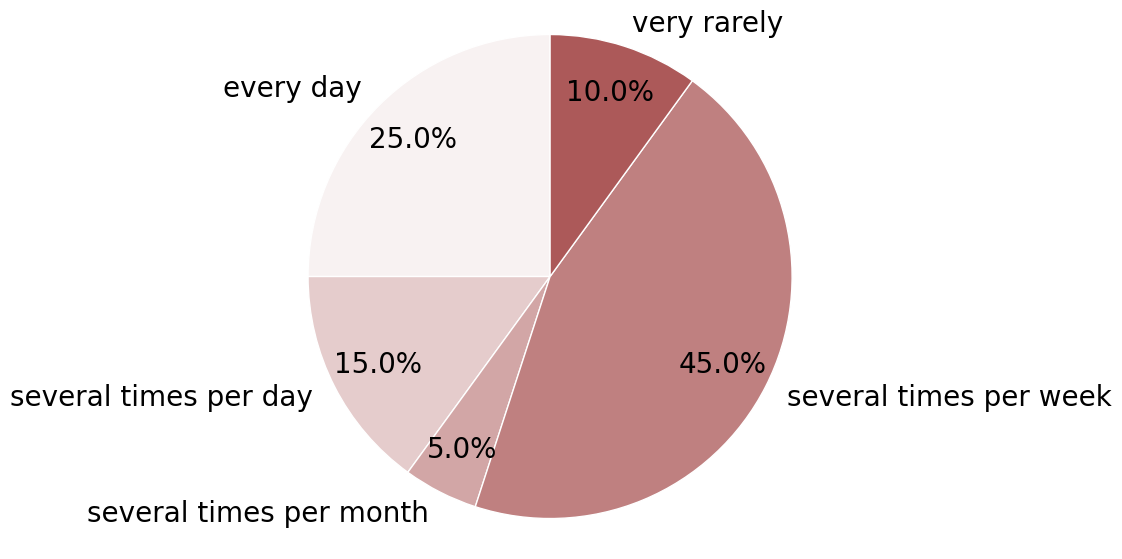

In [180]:
alphas = np.linspace(0.05, 0.8, 6)
teal_rgba = np.array([np.array(list(colors.to_rgba('maroon', alpha=None))),]*6)
teal_rgba[:, 3] = alphas
teal_rgba

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 2 else ''

fig1, ax1 = plt.subplots(figsize=(10,7))
my_pie = ax1.pie(annotators_cons.num_participants, labels=annotators_cons.news_check_frequency,
        startangle=90, textprops={'fontsize': 20}, #labeldistance=None,
        autopct=my_autopct, pctdistance=0.8,
       colors=teal_rgba)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
#ax1.legend(loc='upper right', bbox_to_anchor=(1.15, 0.95))

for pie_wedge in my_pie[0]:
    pie_wedge.set_edgecolor('white')

plt.show()